**Description**: Evaluation of barebones PyTorch implementation of the Gumbel-max trick.

**Estimated runtime**: a few minutes, depends on hardware

In [1]:
from __future__ import annotations
import itertools
from time import time
from typing import Sequence

import numpy as np
import pandas as pd
from scipy.stats import trim_mean, chisquare
import torch
from tqdm.auto import tqdm

In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cpu'

In [3]:
def sample_via_gumbel_max_trick(logits: torch.Tensor) -> torch.Tensor:
    # https://timvieira.github.io/blog/post/2014/07/31/gumbel-max-trick/
    gumbels = -torch.log(-torch.log(torch.rand(*logits.size(), device=logits.device)))
    gumbels_rescaled = logits + gumbels
    max_idxs = gumbels_rescaled.max(dim=-1)[1]
    return max_idxs


def sample_vanilla(logits: torch.Tensor) -> torch.Tensor:
    probs = torch.nn.functional.softmax(logits, dim=-1)
    return torch.multinomial(probs, num_samples=1).squeeze(1)

## Statistical check

Repeated samples from a set of independetly parametrized categorical distributions

In [4]:
sample_size = 10_000  # i.e., the number of tokens to sample
batch_size = 100
vocab_size = 5

logits = torch.randn(size=(batch_size, vocab_size), device=DEVICE)

samples_vanilla = torch.empty(size=(sample_size, batch_size), device=DEVICE)
samples_gumbel = torch.empty(size=(sample_size, batch_size), device=DEVICE)
for i in tqdm(range(sample_size)):
    samples_vanilla[i] = sample_vanilla(logits)
    samples_gumbel[i] = sample_via_gumbel_max_trick(logits)


def empirical_distr(discrete_samples: torch.Tensor):
    # assumes at least 1 sample from each category is present. increase sample_size or
    # decrease vocab_size if that doesn't happen
    # idk how to vectorize the counts computation, but it doesn't matter
    counts = torch.stack([torch.unique(discrete_samples[:, distr_idx],
                                       return_counts=True)[1]
                          for distr_idx in range(discrete_samples.shape[1])])
    # counts has shape (batch size, vocab size)
    return counts / counts.sum(dim=-1, keepdim=True)


empirical_distr_vanilla = empirical_distr(samples_vanilla)
empirical_distr_gumbel = empirical_distr(samples_gumbel)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [5]:
true_distr = logits.softmax(dim=-1)

In [6]:
def rel_error(true_distr: torch.Tensor, empirical_distr: torch.Tensor, dim: int=None):
    return torch.mean((true_distr - empirical_distr) / true_distr, dim=dim).abs()

In [7]:
print('Average relative error (across all distributions and categories):')
print('softmax + multinomial:', rel_error(true_distr, empirical_distr_vanilla).item())
print('     Gumbel-max trick:', rel_error(true_distr, empirical_distr_gumbel).item())

Average relative error (across all distributions and categories):
softmax + multinomial: 0.0007338332943618298
     Gumbel-max trick: 0.0009851192589849234


For thoroughness, run a chi-square goodness of fit test for each distribution.

In [8]:
def _float64_and_normalize(input, dim: int=-1) -> np.ndarray:
    # scipy's chi square test requires distr sums to be 1 up to 1e-8 rtol. need to
    # increase precision and re-normalize the torch float32 distributions to pass this
    # input check
    output = np.array(input).astype(np.float64)
    return output / output.sum(axis=dim, keepdims=True)

In [9]:
true_distr = _float64_and_normalize(true_distr)
empirical_distr_vanilla = _float64_and_normalize(empirical_distr_vanilla)
empirical_distr_gumbel = _float64_and_normalize(empirical_distr_gumbel)

p_values_vanilla = []
p_values_gumbel = []
for distr_idx in range(true_distr.shape[0]):
    p_values_vanilla.append(chisquare(f_obs=empirical_distr_vanilla[distr_idx],
                                      f_exp=true_distr[distr_idx]).pvalue)
    p_values_gumbel.append(chisquare(f_obs=empirical_distr_gumbel[distr_idx],
                                     f_exp=true_distr[distr_idx]).pvalue)
# purposefully not going to correct for multiple comparisons (correction methods
# increase p-values, but we should never see a p-value too far from 1)

In [10]:
print('H0: samples were generated via categorical distribution parametrized by '
      'true_distr.')
print(f'below: *lowest* p-value across {true_distr.shape[0]} categorical '
      f'distributions, each with {true_distr.shape[1]} categories.')
print()
print('softmax + multinomial:', pd.Series(p_values_vanilla).min())
print('     Gumbel-max trick:', pd.Series(p_values_gumbel).min())

H0: samples were generated via categorical distribution parametrized by true_distr.
below: *lowest* p-value across 100 categorical distributions, each with 5 categories.

softmax + multinomial: 0.9999998494542799
     Gumbel-max trick: 0.9999997617951839


## Computational eval

In [11]:
def time_func(func, *args, num_replications: int=50,
              progress_bar_desc: str=None, **kwargs) -> list[float]:
    '''
    Returns a list, `times`, where `times[i]` is the time it took to run
    `func(*args, **kwargs)` at replication `i` of `num_replications`.
    '''
    times = []
    for _ in tqdm(range(num_replications), desc=progress_bar_desc):
        time_start = time()
        _ = func(*args, **kwargs)
        time_end = time()
        times.append(time_end - time_start)
    return times


def collect_sampling_times(batch_sizes: Sequence[int], vocab_sizes: Sequence[int],
                           num_replications: int=50, trim_frac: float=0.0) -> pd.DataFrame:
    times_vanilla = []
    times_gumbel = []
    for batch_size, vocab_size in tqdm(itertools.product(batch_sizes, vocab_sizes),
                                       total=len(batch_sizes) * len(vocab_sizes)):
        progress_bar_desc = f'batch size={batch_size}, vocab size={vocab_size}'
        logits = torch.randn((batch_size, vocab_size), device=DEVICE)
        times_vanilla.append(time_func(sample_vanilla,
                                       logits,
                                       num_replications=num_replications,
                                       progress_bar_desc=progress_bar_desc))
        times_gumbel.append(time_func(sample_via_gumbel_max_trick,
                                      logits,
                                      num_replications=num_replications,
                                      progress_bar_desc=progress_bar_desc + ' (Gumbel)'))
    return pd.DataFrame({'batch size': np.repeat(batch_sizes, len(vocab_sizes)),
                         'vocab size': np.tile(vocab_sizes, len(batch_sizes)),
                         'softmax + multinomial': trim_mean(times_vanilla, trim_frac, axis=1),
                         'Gumbel-max trick': trim_mean(times_gumbel, trim_frac, axis=1)})

In [12]:
batch_sizes = np.power(2, np.arange(0, 5)) # 10
vocab_sizes = np.power(2, np.arange(5, 10)) # 17

times_df = collect_sampling_times(batch_sizes, vocab_sizes)

  0%|          | 0/25 [00:00<?, ?it/s]

batch size=1, vocab size=32:   0%|          | 0/50 [00:00<?, ?it/s]

batch size=1, vocab size=32 (Gumbel):   0%|          | 0/50 [00:00<?, ?it/s]

batch size=1, vocab size=64:   0%|          | 0/50 [00:00<?, ?it/s]

batch size=1, vocab size=64 (Gumbel):   0%|          | 0/50 [00:00<?, ?it/s]

batch size=1, vocab size=128:   0%|          | 0/50 [00:00<?, ?it/s]

batch size=1, vocab size=128 (Gumbel):   0%|          | 0/50 [00:00<?, ?it/s]

batch size=1, vocab size=256:   0%|          | 0/50 [00:00<?, ?it/s]

batch size=1, vocab size=256 (Gumbel):   0%|          | 0/50 [00:00<?, ?it/s]

batch size=1, vocab size=512:   0%|          | 0/50 [00:00<?, ?it/s]

batch size=1, vocab size=512 (Gumbel):   0%|          | 0/50 [00:00<?, ?it/s]

batch size=2, vocab size=32:   0%|          | 0/50 [00:00<?, ?it/s]

batch size=2, vocab size=32 (Gumbel):   0%|          | 0/50 [00:00<?, ?it/s]

batch size=2, vocab size=64:   0%|          | 0/50 [00:00<?, ?it/s]

batch size=2, vocab size=64 (Gumbel):   0%|          | 0/50 [00:00<?, ?it/s]

batch size=2, vocab size=128:   0%|          | 0/50 [00:00<?, ?it/s]

batch size=2, vocab size=128 (Gumbel):   0%|          | 0/50 [00:00<?, ?it/s]

batch size=2, vocab size=256:   0%|          | 0/50 [00:00<?, ?it/s]

batch size=2, vocab size=256 (Gumbel):   0%|          | 0/50 [00:00<?, ?it/s]

batch size=2, vocab size=512:   0%|          | 0/50 [00:00<?, ?it/s]

batch size=2, vocab size=512 (Gumbel):   0%|          | 0/50 [00:00<?, ?it/s]

batch size=4, vocab size=32:   0%|          | 0/50 [00:00<?, ?it/s]

batch size=4, vocab size=32 (Gumbel):   0%|          | 0/50 [00:00<?, ?it/s]

batch size=4, vocab size=64:   0%|          | 0/50 [00:00<?, ?it/s]

batch size=4, vocab size=64 (Gumbel):   0%|          | 0/50 [00:00<?, ?it/s]

batch size=4, vocab size=128:   0%|          | 0/50 [00:00<?, ?it/s]

batch size=4, vocab size=128 (Gumbel):   0%|          | 0/50 [00:00<?, ?it/s]

batch size=4, vocab size=256:   0%|          | 0/50 [00:00<?, ?it/s]

batch size=4, vocab size=256 (Gumbel):   0%|          | 0/50 [00:00<?, ?it/s]

batch size=4, vocab size=512:   0%|          | 0/50 [00:00<?, ?it/s]

batch size=4, vocab size=512 (Gumbel):   0%|          | 0/50 [00:00<?, ?it/s]

batch size=8, vocab size=32:   0%|          | 0/50 [00:00<?, ?it/s]

batch size=8, vocab size=32 (Gumbel):   0%|          | 0/50 [00:00<?, ?it/s]

batch size=8, vocab size=64:   0%|          | 0/50 [00:00<?, ?it/s]

batch size=8, vocab size=64 (Gumbel):   0%|          | 0/50 [00:00<?, ?it/s]

batch size=8, vocab size=128:   0%|          | 0/50 [00:00<?, ?it/s]

batch size=8, vocab size=128 (Gumbel):   0%|          | 0/50 [00:00<?, ?it/s]

batch size=8, vocab size=256:   0%|          | 0/50 [00:00<?, ?it/s]

batch size=8, vocab size=256 (Gumbel):   0%|          | 0/50 [00:00<?, ?it/s]

batch size=8, vocab size=512:   0%|          | 0/50 [00:00<?, ?it/s]

batch size=8, vocab size=512 (Gumbel):   0%|          | 0/50 [00:00<?, ?it/s]

batch size=16, vocab size=32:   0%|          | 0/50 [00:00<?, ?it/s]

batch size=16, vocab size=32 (Gumbel):   0%|          | 0/50 [00:00<?, ?it/s]

batch size=16, vocab size=64:   0%|          | 0/50 [00:00<?, ?it/s]

batch size=16, vocab size=64 (Gumbel):   0%|          | 0/50 [00:00<?, ?it/s]

batch size=16, vocab size=128:   0%|          | 0/50 [00:00<?, ?it/s]

batch size=16, vocab size=128 (Gumbel):   0%|          | 0/50 [00:00<?, ?it/s]

batch size=16, vocab size=256:   0%|          | 0/50 [00:00<?, ?it/s]

batch size=16, vocab size=256 (Gumbel):   0%|          | 0/50 [00:00<?, ?it/s]

batch size=16, vocab size=512:   0%|          | 0/50 [00:00<?, ?it/s]

batch size=16, vocab size=512 (Gumbel):   0%|          | 0/50 [00:00<?, ?it/s]

In [13]:
# filename = 'gumbel_times.csv'
# times_df.to_csv(filename)

# def is_using_colab():
#     try:
#         import google.colab
#     except:
#         return False
#     else:
#         return True

# if is_using_colab():
#     from google.colab import files
#     files.download(filename)

In [14]:
mask_faster = times_df['softmax + multinomial'] > times_df['Gumbel-max trick']
print(f'The Gumbel-max trick is faster in {mask_faster.sum()} out of {len(times_df)} '
      f'configurations (on {DEVICE.upper()}).')
print("Here are the configurations where it's slower:")
times_df[~mask_faster]

The Gumbel-max trick is faster in 14 out of 25 configurations (on CPU).
Here are the configurations where it's slower:


,batch size,vocab size,softmax + multinomial,Gumbel-max trick
5,2,32,0.000240,0.000780
6,2,64,0.000280,0.000400
7,2,128,0.000260,0.000500
9,2,512,0.000520,0.000579
10,4,32,0.000259,0.000420
11,4,64,0.000242,0.006540
12,4,128,0.000220,0.001100
16,8,64,0.000317,0.000423
17,8,128,0.000417,0.000420
20,16,32,0.000320,0.000340


In [15]:
def barplot(batch_size: int=None, vocab_size: int=None):
    if ((batch_size is None and vocab_size is None) or
        (batch_size is not None and vocab_size is not None)):
        raise ValueError('Either batch_size or vocab_size must be passed.')
    val = batch_size or vocab_size
    select, index = 'batch size', 'vocab size'
    if vocab_size is not None:
        select, index = 'vocab size', 'batch size'

    (times_df.copy()
     [times_df[select] == val]
     .drop(columns=[select])
     .set_index(index)
     .plot.bar(ylabel='mean wall-clock time (sec)',
               title=f'Sampling time ({select} = {val}, device = {DEVICE})'));

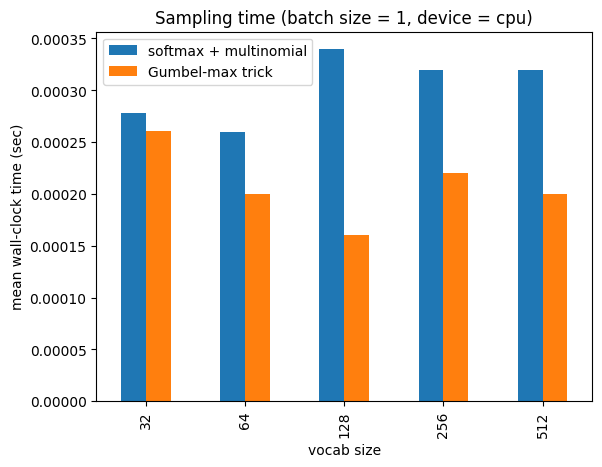

In [16]:
barplot(batch_size=1)

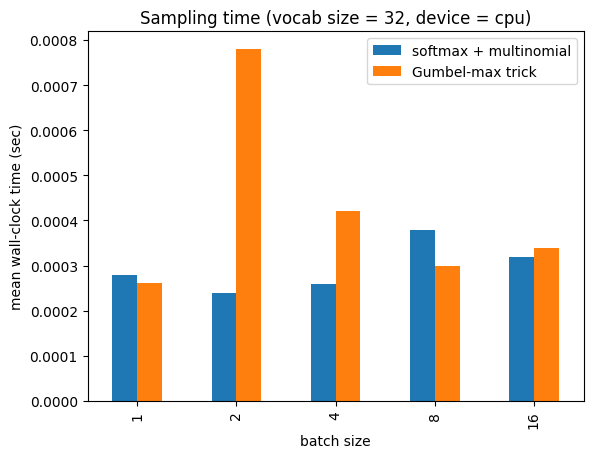

In [17]:
barplot(vocab_size=32)